# Feature Analysis (Integrated Gradients)

In [1]:
from phply.phpparse import make_parser
from phply import phpast as ast
from phply import phplex
from data.preprocessing import sub_tokens
from data.wirecaml_utils.my_php_listener import MyPHPListener
from data.wirecaml_utils.phptraverser import php_traverser
import intervaltree
import os
import re
import pickle
import torch
from model import PhpNetGraphTokensCombine
from data.preprocessing import sub_tokens
from data.preprocessing import map_tokens
from torch_geometric.data import Data
import main
import numpy as np
from torch_geometric.data import DataLoader, DataListLoader, Batch
import random
import pandas as pd
import activations as act

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# directory to search
#dir = "data/SARD/SQLi/CWE_89/unsafe"
#dir = "data/SARD/XSS/CWE_79/unsafe"
#dir = "data/SARD/Command injection/CWE_78/unsafe"
dir = "TestSet"

target_vuln = 1 # 9999 if UNKNOWN

asd=[]


data_ls = []
no_flaws = 0
parser = make_parser()
lexer = phplex.lexer.clone()
ignore_tokens = ['LBRACE','RBRACE']

def process(line, allfuncs,allvars):
    lexer = phplex.lexer.clone()
    code_tokens = []
    lexer.input("<?php " + line)
    while True:
        tok = lexer.token()
        if not tok:
            break
        if tok in ignore:
            continue
        tok = sub_tokens.sub_token(tok,None,allvars)
        code_tokens.append(tok)
    return map_tokens.tokenise(code_tokens)

def getLines(filepath):
    lines = []
    with open(filepath) as f:
        s = f.read()
        inserts_deletes = s.split("@@")
        for phrase in inserts_deletes:
            if phrase is None or phrase == '' or phrase == ' ' or phrase == '\n':
                continue
            out = re.split(" |,|\-",phrase)
            out = list(filter(lambda i: i != '',out))
            if ('+' in out[len(out) - 1]) or ('+' not in out[len(out) - 1] and int(out[len(out) - 1]) > 0):
                lines.append(int(out[0]))
    return lines

def get_tokens(data):
    lexer2 = phplex.lexer.clone()
    lexer2.input(data)
    codetokens = []
    synerror = False
    while True:
        try:
            tok = lexer2.token()
        except IndexError:
            break
        except SyntaxError:
            print("syntax error :(")
            synerror = True
            break
        if not tok:
            break
        if tok in ignore:
            continue
        tok = sub_tokens.sub_token(tok)
        codetokens.append(tok)
    if synerror:
        return None
    return codetokens

def RepresentsInt(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

def _compute_interval(node):
    min_lineno = node.lineno
    max_lineno = node.lineno

    allsubnodes = []
    def visitor_subnodes(node):
        if isinstance(node, ast.Node):
            allsubnodes.append(node)
    node.accept(visitor_subnodes)
    for node in allsubnodes:
        if hasattr(node, "lineno") and node.lineno != None and node.lineno != 0:
            min_lineno = min(min_lineno, node.lineno)
            max_lineno = max(max_lineno, node.lineno)
    return (min_lineno, max_lineno + 1)

def file_to_tree(filename):
    parser = make_parser()
    lexer = phplex.lexer.clone()
    try:
        with open(filename,encoding='utf-8') as f:
            file_content = f.read()
            if len(file_content.split("<?php")) > 2:
                return None
            parsed = parser.parse(file_content, lexer=lexer)
    except UnicodeDecodeError:
        print("error decoding " + filename)
        return None
    except SyntaxError:
        print("error syntax " + filename)
        return None
    tree = intervaltree.IntervalTree()
    allnodes = []
    def visitor(node):
        if isinstance(node, ast.Function):
            allnodes.append(node)
        elif isinstance(node, ast.Method):
            allnodes.append(node)

    for node in parsed:
        node.accept(visitor)

    for node in allnodes:
        if isinstance(node, (ast.Function, ast.Class, ast.Method)):
            start, end = _compute_interval(node)
            tree[start:end] = node
    return tree



device=torch.device('cuda')

def get_all_funcs(nodes):
    allfuncs = []
    for node in nodes:
        allfuncs.extend(node.stmt_funcs)
    return allfuncs
vuln_dict = {1:"SQLi",2:"XSS",3:"CI"}
model = PhpNetGraphTokensCombine()
model.load_state_dict(torch.load("model_combine.pt"))
model.to("cuda")
model.eval()

model = act.set_eval_zerodrop(model)

ignore = {'WHITESPACE', 'OPEN_TAG', 'CLOSE_TAG'}
vulns = 0
funcs = 0
predicted = []

########## START  ADDED

all_pred=[]
all_lbl=[]
all_codes=[]
all_graphs=[]
all_graphs_len=[]
sensitivity_grad=[]
sensitivity_grad_graph=[]
all_filenames=[]
all_ig=[]
all_ig_graph=[]

all_grad=[]
########END ADDED

for root, dirs, files in os.walk(dir):
    for filename in files:
        file = root + os.sep + filename
        if ".php" in file:
            matches = file_to_tree(file)
            # print(matches)
            if matches is None or len(matches) == 0:
                matches = [None]

            if matches:
                for match in matches:
                    funcs += 1
                    with open(file, "r") as myfile:
                        code_tokens = []
                        lexer = phplex.lexer.clone()
                        parser = make_parser()
                        if match is not None:
                            interval = min([match], key=lambda i: i[1] - i[0])

                            func_lines = ["<?php "]
                            startsopen = False
                            no_braces = 0
                            try:
                                for i, line in enumerate(myfile):
                                    if i >= interval[1]:
                                        break
                                    elif i >= interval[0]:
                                        if line.strip() == "{" and i == interval[0]:
                                            startsopen = True
                                            continue
                                        elif line.strip() == "}" and i == (interval[1] - 1) and no_braces == 0:
                                            continue

                                        if '{' in line:
                                            no_braces += line.count('{')
                                        if '}' in line:
                                            no_braces -= line.count('}')
                                        func_lines.append(line)
                            except UnicodeDecodeError:
                                print("unidecode error")
                                continue
                            data = ''.join(func_lines)
                        else:
                            try:
                                data = myfile.read()
                            except UnicodeDecodeError:
                                print("unidecode error")
                                continue
                        try:
                            nodes = parser.parse(data, lexer=lexer, tracking=True, debug=False)
                        except:
                            print("parsing error")
                            print("here " + file)
                            continue
                        listener = MyPHPListener(name=file)

                        php_traverser.traverse(nodes, listener)

                        cfg = listener.get_graph()
                        allvars = set()
                        for node in list(cfg.nodes):
                            for var in node.stmt_vars:
                                allvars.add(var)

                        allfuncs = get_all_funcs(cfg.nodes)
                        edges = [[list(cfg.nodes).index(i), list(cfg.nodes).index(j)] for (i, j) in cfg.edges]


                        if len(edges) == 0:
                            continue
                        edges = torch.tensor(edges, dtype=torch.long)
                        try:
                            graph_nodes = torch.tensor([process(node.text, allfuncs, list(allvars)) for node in list(cfg.nodes)])
                        except Exception as e:
                            print("Tokenising error " + file)
                            continue
                        data_graph = Data(x=graph_nodes, edge_index=edges.t().contiguous())
                        asd.append(data_graph)
                        lexer = phplex.lexer.clone()
                        lexer.input(data)
                        synerror = False
                        while True:
                            try:
                                tok = lexer.token()
                            except IndexError:
                                break
                            except SyntaxError:
                                print("syntax error :(")
                                synerror = True
                                break
                            if not tok:
                                break
                            if tok in ignore:
                                continue
                            tok = sub_tokens.sub_token(tok,allfuncs,list(allvars))
                            code_tokens.append(tok)
                        
                        out1,out2 = act.get_graph_tokens(graph_nodes) ## added
                        all_graphs.append(out1) ## added
                        all_graphs_len.append(out2) ## added
                        all_filenames.append(file) ## added
                        data_tokens = main.get_data_custom([code_tokens]) ## edited, return encoder
                        all_codes.append(np.array(data_tokens[0].detach()).astype(int)) ## added
                        all_lbl.append(target_vuln) ## added
                        
                        data_token_in = data_tokens.to(device=device, dtype=torch.long)
                        data_graph_batch = Batch.from_data_list([data_graph]).to(device)
                        pred = model(data_graph_batch,data_token_in)
                        
                        sensitivity_weight,sensitivity_grad_batch,grad = act.get_weights_grads_from_model(model,pred,'embed') ## added
                        sensitivity_grad.append(sensitivity_grad_batch) ## added

                        sensitivity_weight_graph,sensitivity_grad_graph_batch,grad_graph = act.get_weights_grads_from_model(model,pred,'embed1') ## added
                        sensitivity_grad_graph.append(sensitivity_grad_graph_batch) ## added
                        
                        ig = act.integrated_gradients((data_graph_batch,data_token_in),model,device,False,'embed',50) ## added
                        all_ig.append(ig)
                        
                        ig = act.integrated_gradients((data_graph_batch,data_token_in),model,device,True,'embed1',50) ## added
                        all_ig_graph.append(ig)
                        
                        vals = pred.cpu().detach().numpy()
                        preds = np.argmax(vals, axis=1)
                            
                        if preds > 0:
                            all_pred.append(preds[0]) ## added
                            print("Found Vuln")
                            print(vuln_dict[preds[0]])
                            predicted.append(vuln_dict[preds[0]])
                            print("in")
                            print(file)
                            if match is not None:
                                print("function")
                                print(match[2])
                            #print("code body is")
                            #print(data)
                            print("NEXT")
                            vulns+=1
                        else:
                            all_pred.append(0) ## added
                            predicted.append('Safe')


print('\nTotal predicted as vulnerable: ',vulns)
print('Total functions: ',funcs)
print('\nPredicted distribution:')
print(pd.value_counts(predicted))

4416
(9878, 2)
Found Vuln
SQLi
in
TestSet/incorrect_sqli_1.php
NEXT
Found Vuln
SQLi
in
TestSet/incorrect_sqli_2.php
NEXT
Found Vuln
SQLi
in
TestSet/correct_sqli_1.php
NEXT
Found Vuln
SQLi
in
TestSet/correct_sqli_2.php
NEXT
Found Vuln
XSS
in
TestSet/.ipynb_checkpoints/test_2_194-checkpoint.php
NEXT
Found Vuln
SQLi
in
TestSet/.ipynb_checkpoints/incorrect_sqli_1-checkpoint.php
NEXT

Total predicted as vulnerable:  6
Total functions:  7

Predicted distribution:
SQLi    5
XSS     1
Safe    1
dtype: int64


In [2]:
from torchnlp.encoders import LabelEncoder

mydf = act.process_activation(sensitivity_weight, 
                              sensitivity_grad,
                              all_ig,
                              all_codes,
                              LabelEncoder(main.tokens),
                              all_pred,
                              all_lbl,
                              all_filenames)

In [3]:
mydf_graph = act.process_activation(sensitivity_weight_graph, 
                              sensitivity_grad_graph,
                              all_ig_graph,
                              all_graphs,
                              map_tokens.encoder,
                              all_pred,
                              all_lbl,
                              all_filenames,
                              all_graphs_len)

In [4]:
mydf_graph.predicted

0    1
1    1
2    0
3    1
4    1
5    2
6    1
Name: predicted, dtype: int64

In [5]:
mydf_graph[1==mydf_graph.predicted].index

Int64Index([0, 1, 3, 4, 6], dtype='int64')

In [6]:
idx = 0

In [7]:
#act.display_weights(mydf,idx)

In [8]:
#act.display_weights(mydf_graph,idx)

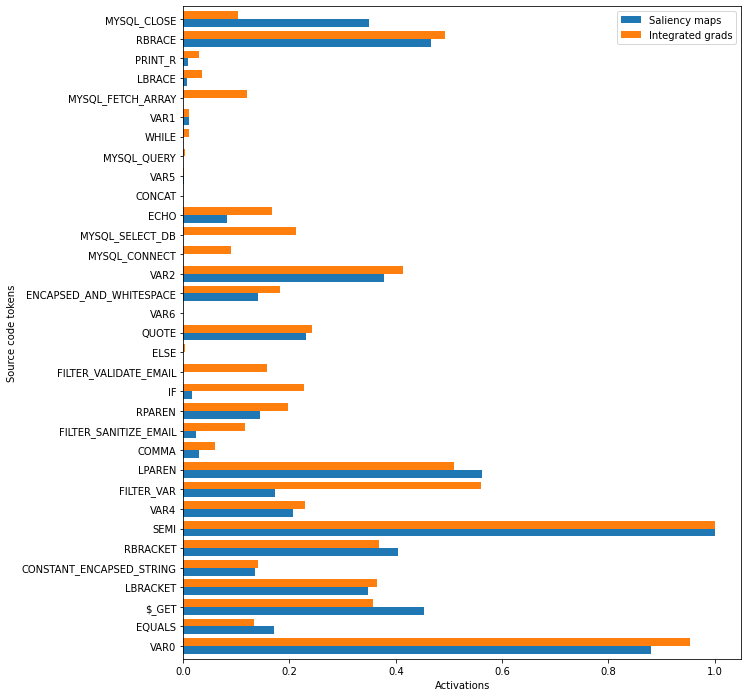

In [9]:
act.display_activations(mydf,idx)

### The graph data (nodes)

In [10]:
asd[idx].x

tensor([[293, 223,  64, 242, 279, 243,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [297, 223, 105, 240, 293, 247, 124, 241,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [163, 240, 105, 240, 297, 247, 125, 241, 241,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [293, 223, 297,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [293, 223, 279,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [299, 223, 281, 280, 281, 248, 293, 248, 281, 280, 281,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [295, 223,  23, 240, 279, 247, 279, 247, 279, 241,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [ 24, 240, 279, 241,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [ 56, 279, 248, 299, 248, 279,   0,   0,

### Translated graph data (nodes)

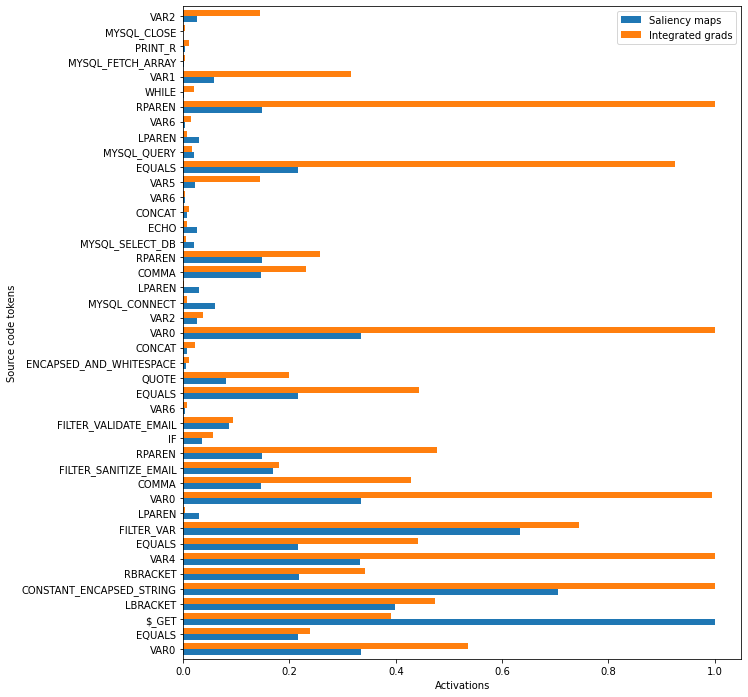

In [11]:
act.display_activations(mydf_graph,idx)

In [12]:
act.display_func(mydf_graph,idx)

<?php
/* 
Unsafe sample
input : reads the field UserData from the variable $_GET
Uses an email_filter via filter_var function
construction : interpretation with simple quote
*/



/*Copyright 2015 Bertrand STIVALET 

Permission is hereby granted, without written agreement or royalty fee, to

use, copy, modify, and distribute this software and its documentation for

any purpose, provided that the above copyright notice and the following

three paragraphs appear in all copies of this software.


IN NO EVENT SHALL AUTHORS BE LIABLE TO ANY PARTY FOR DIRECT,

INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES ARISING OUT OF THE 

USE OF THIS SOFTWARE AND ITS DOCUMENTATION, EVEN IF AUTHORS HAVE

BEEN ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


AUTHORS SPECIFICALLY DISCLAIM ANY WARRANTIES INCLUDING, BUT NOT

LIMITED TO THE IMPLIED WARRANTIES OF MERCHANTABILITY, FITNESS FOR A

PARTICULAR PURPOSE, AND NON-INFRINGEMENT.


THE SOFTWARE IS PROVIDED ON AN "AS-IS" BASIS AND AUTHORS HAVE NO

OB

In [13]:
mydf_graph.filename[idx]

'TestSet/incorrect_sqli_1.php'